# Lonlat ms diagnosis on main combination

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import dask.dataframe as dd
import os
from glob import glob

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo

import matplotlib.transforms as mtransforms
crs = ccrs.PlateCarree()

import histlib.matchup as match
from  histlib.diagnosis import build_matchup_dataframe, synthetic_figure, path_csv, put_fig_letter, lonlat_stats
from histlib.cstes import labels, zarr_dir, matchup_dir, c0, U
U2 =U**2

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


# Load lonlat mean

In [2]:
DL, DT = 25e3, 30*60
comb_25 = {'acc':'drifter_acc_x_25','cor':'drifter_coriolis_x_25','ggx':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wd':'es_cstrio_z15_drifter_wd_x'}
dsm = xr.open_dataset(path_csv(comb_25, 'both', True, DL, DT).replace('analysis_files/', 'analysis_files/lonlat_').replace('.csv', '.nc'))


# re-Scale with U2
vars_errors = ['B_acc', 'E_acc', 'E_cor', 'B_cor', 'E_ggx', 'B_ggx', 'E_wd', 'B_wd',
 'X_acc_cor', 'X_acc_ggx', 'X_acc_wd', 'X_cor_ggx', 'X_cor_wd','X_ggx_wd', 
 'ACC', 'COR', 'GGX', 'WD', 'S', 'sigma']
vars = ['acc_cor','acc_ggx','acc_wd','cor_ggx','cor_wd','ggx_wd',
 'E_acc','B_acc','E_cor','B_cor','E_ggx','B_ggx','E_wd','B_wd',
 'X_acc_cor','X_acc_ggx','X_acc_wd','X_cor_ggx','X_cor_wd','X_ggx_wd',
 'ACC','COR','GGX','WD','S','sigma',] + ['be__'+v for v in vars_errors]
for v in vars :
    dsm[v] = dsm[v]/U2

# Relative error
for v in vars_errors :
    dsm['ratio__'+v] = abs(dsm['be__'+v]/dsm[v])

______________________
# Fig function

In [3]:
def plot_total_lonlat_hist(var, ax, bins=30) :
    v = var.values.ravel()
    v = v[~np.isnan(v)]
    hist, bedge = np.histogram(v, bins=bins)
    ax.plot(bedge[:-1] + (bedge[1]-bedge[0])/2, hist)

def plot_lonlat(var,ax, letter=None, retins=False, **kwargs):
    dkwargs = dict(cmap='viridis')
    dkwargs.update(kwargs)
    var.plot(ax=ax, transform=ccrs.PlateCarree(), **kwargs)
    if letter : 
        put_fig_letter(fig, ax, letter)
    ins = ax.inset_axes(ins_ax_box)
    plot_total_lonlat_hist(var, ins)
    ins.grid()
    ins.set_yticks([])
    ins.set_xlabel('')
    bbox = dict(ec="w", fc="w", alpha=0.8)
    plt.setp(ins.get_xticklabels(), bbox=bbox)
    ins.annotate('Distribution',(0.5, 0.8), xycoords = 'axes fraction', horizontalalignment='center')
    ins.xaxis.get_offset_text().set(bbox=bbox)
    if retins:
        return ins

## Inserted box
#ins_ax_box = [0.66,0.73,0.25,0.27]
ins_ax_box = [0.56,0.7,0.29,0.3]

______________
# Filter value where the relative error on S is bigger than elim =0.2 

In [33]:
#CHOOSE error percentage limite 
elim = 0.5
test = dsm['ratio__S']<elim # keep only bins where S relative error is below 20%
ds = dsm.where(dsm['ratio__S']<elim)

In [34]:
for v in [v for v in dsm if 'X' in v] :
    ds[v+'__sigma'] = ds[v]/ds['sigma']*100

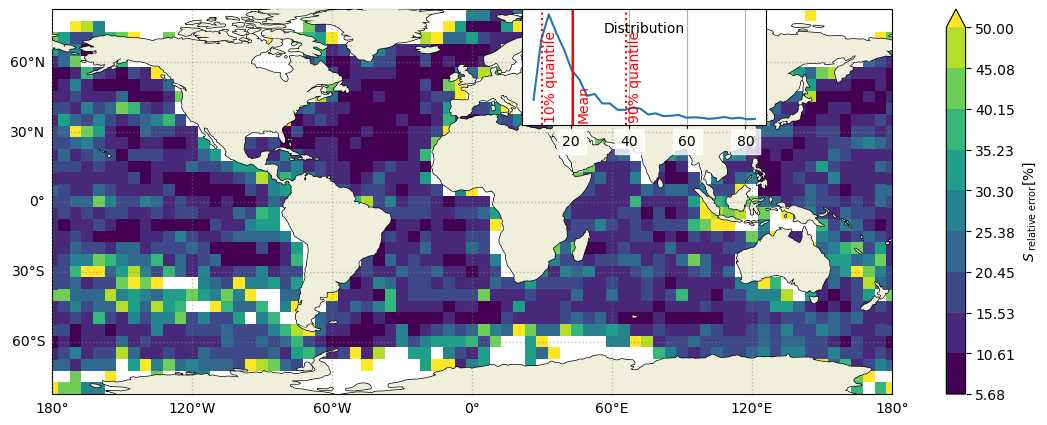

In [35]:
fig, ax = plt.subplots(1,1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,5), frameon=False)
ne = (dsm['ratio__S']*100).assign_attrs({'long_name':r'$S_{\text{ relative error}}$[%]'})
ins = plot_lonlat(ne, ax,'', levels=10,vmax=50, retins=True)

#mean, quartile
ne_ = ne.values.ravel()
ne_ = ne_[~np.isnan(ne_)]
ins.axvline(ne_.mean(), c='r')
ins.annotate('Mean',(ne_.mean()+1, 1), color='r', rotation=90)
ins.axvline(np.percentile(ne_, 10), ls=':', c='r')
ins.annotate('10% quantile',(np.percentile(ne_, 10)+1, 1), color='r', rotation=90)
ins.axvline(np.percentile(ne_, 90), ls=':', c='r')
ins.annotate('90% quantile',(np.percentile(ne_, 90)+1, 1), color='r', rotation=90)
ax.add_feature(cfeature.LAND, zorder=5)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
gl.xlabels_top = False
gl.ylabels_right = False
#ax.set_title('Along-track')
#fig.savefig('../images_all/lonlat_msre_err_alg.png', bbox_inches='tight', dpi=300)


_________
# Select areas

In [36]:
# Gulf Stream 
area_geo = ds['X_cor_ggx__sigma']>70
gulf_stream = area_geo.where(area_geo.lonbin<-10, False).where(area_geo.latbin>15, False).where(area_geo.lonbin>-85, False).where(area_geo.latbin<50, False)
# ACC 
testlat = (ds.latbin<-35)
area_geo = ds['X_cor_ggx__sigma']>45
acc = area_geo.where(testlat, False)
# North Pacific
area_geo = ds['X_acc_cor__sigma']>10
testlon = (ds.lonbin<-120)| (ds.lonbin>150)
testlat = (ds.latbin>40)
north_pacific = area_geo.where(testlat & testlon, False)
# Tropics
testlat = (ds.latbin<15)&(ds.latbin>-15)
tropics = ds['X_cor_ggx__sigma'].where(testlat, False)

areas = {'GS':gulf_stream, 'ACC':acc, 'NP':north_pacific, 'EQ':tropics}
color_areas = {'Gulf Stream':'red', 'ACC':'darkorange', 'North Pacific':'magenta', 'EQ':'salmon'}

def plot_areas(ax, lw=1.5):
    # Gulf Stream
    gulf_stream.plot.contour(ax=ax, levels=1, colors=[color_areas['Gulf Stream']],linewidths=lw, transform=ccrs.PlateCarree())
    ax.annotate('GS', (-90, 35), zorder=6, c=color_areas['Gulf Stream'], bbox=dict(facecolor='w', edgecolor='none', pad=3.0))
    #ACC
    acc.plot.contour(ax=ax, levels=1, colors=[color_areas['ACC']], linewidths=lw,transform=ccrs.PlateCarree())
    ax.annotate('ACC', (-120, -83), zorder=6, c=color_areas['ACC'], bbox=dict(facecolor='w', edgecolor='none', pad=3.0))
    #Equator
    ax.axhline(-15, lw=lw, c=color_areas['North Pacific'])
    ax.axhline(15, lw=lw, c=color_areas['North Pacific'])
    ax.annotate('EQ', (10, 0), zorder=6, c=color_areas['North Pacific'], bbox=dict(facecolor='w', edgecolor='none', pad=3.0))
    # North_pacific
    north_pacific.plot.contour(ax=ax, levels=1, colors=[color_areas['EQ']],linewidths=lw, transform=ccrs.PlateCarree())
    ax.annotate('NP', (-160, 64), zorder=6, c=color_areas['EQ'], bbox=dict(facecolor='w', edgecolor='none', pad=3.0))

In [37]:
## Numbers of coloc per areas
for a in areas : 
    print(a,ds.where(areas[a]).nb_coloc_bin.sum())

GS <xarray.DataArray 'nb_coloc_bin' ()>
array(6279.)
ACC <xarray.DataArray 'nb_coloc_bin' ()>
array(45128.)
NP <xarray.DataArray 'nb_coloc_bin' ()>
array(17719.)
EQ <xarray.DataArray 'nb_coloc_bin' ()>
array(40408.)


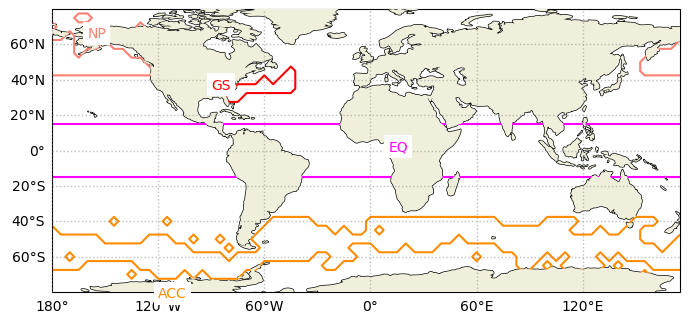

In [38]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, ax = plt.subplots(1,1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(7,4))
title = ['Coriolis - Pressure gradient', 'Lagrangian acceleration - Coriolis acceleration', 'Lagrangian acceleration - Pressure gradient','Coriolis acceleration - wind term',]


label = r"Normalized pair's contribution $X_{ij}/\Sigma$"

plot_areas(ax)

ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
gl.xlabels_top = False
gl.ylabels_right = False

#fig.suptitle("Along-track")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)

______________________
# Distribution of colocalization per bins + coverage

In [39]:
min_coloc_bin = 30
ds['nb_coloc_bin'].attrs = {'long_name': 'Number of colocations per bin'}

Text(0.5, 0.8, 'Distribution')

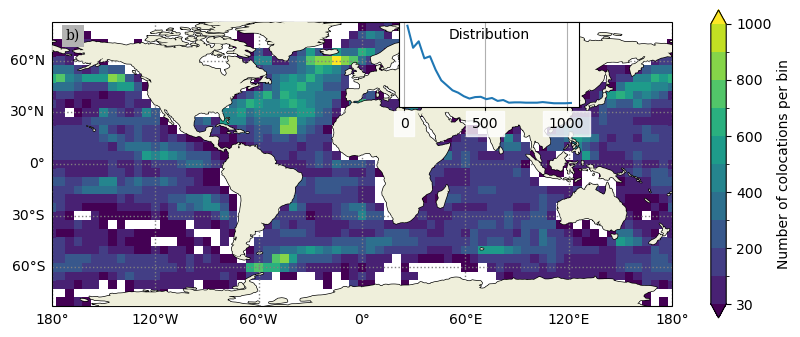

In [40]:
fig = plt.figure(figsize=(10,4), frameon=False)
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ds.where(ds.nb_coloc_bin> 0).nb_coloc_bin.plot(x='lonbin', y='latbin', cmap='viridis', levels=[min_coloc_bin]+list(np.arange(100, 1100, 100)), ax=ax, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=5)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=1, linestyle=':', zorder=2)
gl.xlabels_top = False
gl.ylabels_right = False

ins = ax.inset_axes(ins_ax_box)
plot_total_lonlat_hist(ds.where(ds.nb_coloc_bin> 0).nb_coloc_bin, ins)
bbox = dict(ec="w", fc="w", alpha=0.8)
plt.setp(ins.get_xticklabels(), bbox=bbox)

put_fig_letter(fig, ax, 'b')

ins.grid()
ins.set_yticks([])
ins.annotate('Distribution',(0.5, 0.8), xycoords = 'axes fraction', horizontalalignment='center')

#fig.savefig('../images_all/lonlat_distrib.png',bbox_inches='tight',   dpi=300)

In [41]:
# GET CONTINENT MASK TO QUANTIFIED COVERAGED
proj = {'projection': ccrs.PlateCarree()}
lon = np.arange(-180, 180)
lat = np.arange(-90, 90)
fig, ax = plt.subplots(figsize=(len(lon)/10000, len(lat)/10000), dpi=10000, subplot_kw=proj)
fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0)
ax.set_frame_on(False)
ax.add_feature(cfeature.LAND, facecolor='black')
fig.canvas.draw()
mask = fig.canvas.tostring_rgb()
ncols, nrows = fig.canvas.get_width_height()
plt.close(fig)

mask = np.frombuffer(mask, dtype=np.uint8).reshape(nrows, ncols, 3)
mask = mask.mean(axis=2)
mask = np.flip(mask, axis=0)
mask = xr.DataArray(mask, coords={ 'latbin':lat, 'lonbin':lon,})
mask = mask.interp_like(ds)
mask = mask.where(mask==255, 0).where(mask!=255, 1)
d_mask = ds.where(test, 2).where(mask,1).acc
no_value = np.sum((d_mask== 2).values)
cont_value = np.sum((d_mask== 1).values)
full_value = np.sum((d_mask<1).values)
print(f'Coverage:{full_value/(full_value+no_value)*100}%')

Coverage:86.58777120315581%


In [42]:
#d_mask.plot()

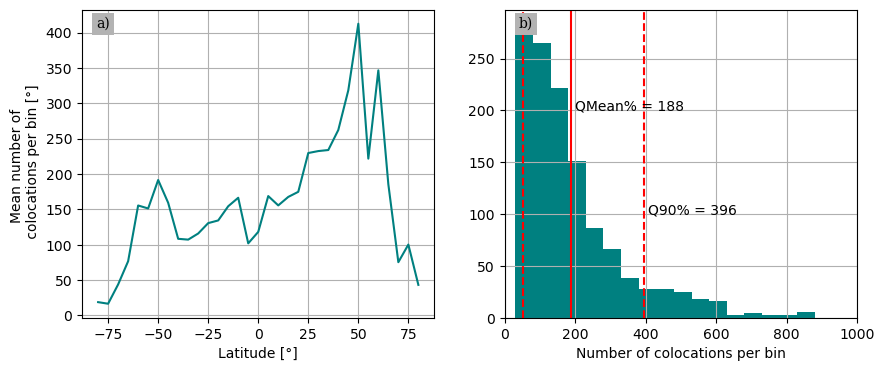

In [43]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
ax=axs[0]
ds.where(ds.nb_coloc_bin> 0).nb_coloc_bin.mean('lonbin').plot(ax=ax, c='teal')
ax.set_xlabel('Latitude [°]')
ax.set_ylabel('Mean number of \n colocations per bin [°]')
ax.grid()
put_fig_letter(fig, ax, 'a')

ax =axs[1]
dd = 10
_ds = ds.where(ds.nb_coloc_bin> min_coloc_bin).nb_coloc_bin
hist = _ds.plot.hist(bins=np.arange(30,4000, 50), ax=ax, color='teal')
mean = _ds.mean().values
q90 = _ds.quantile(0.9).values
q10 = _ds.quantile(0.1).values
ax.axvline(mean, color = 'red')
ax.axvline(q90, color = 'red', ls='--')
ax.axvline(q10, color = 'red', ls='--')
ax.annotate(f'Q10% ={int(q10)}',(q10+dd, 300))
ax.annotate(f'Q90% = {int(q90)}',(q90+dd, 100))
ax.annotate(f'QMean% = {int(mean)}',(mean+dd, 200))
ax.grid()
ax.set_xlim(0, 1000)
put_fig_letter(fig, ax, 'b')

#fig.savefig('../images_all/lonlat_coloc_hist.png',  bbox_inches='tight',  dpi=300)

______________________
# Total figure S + error part

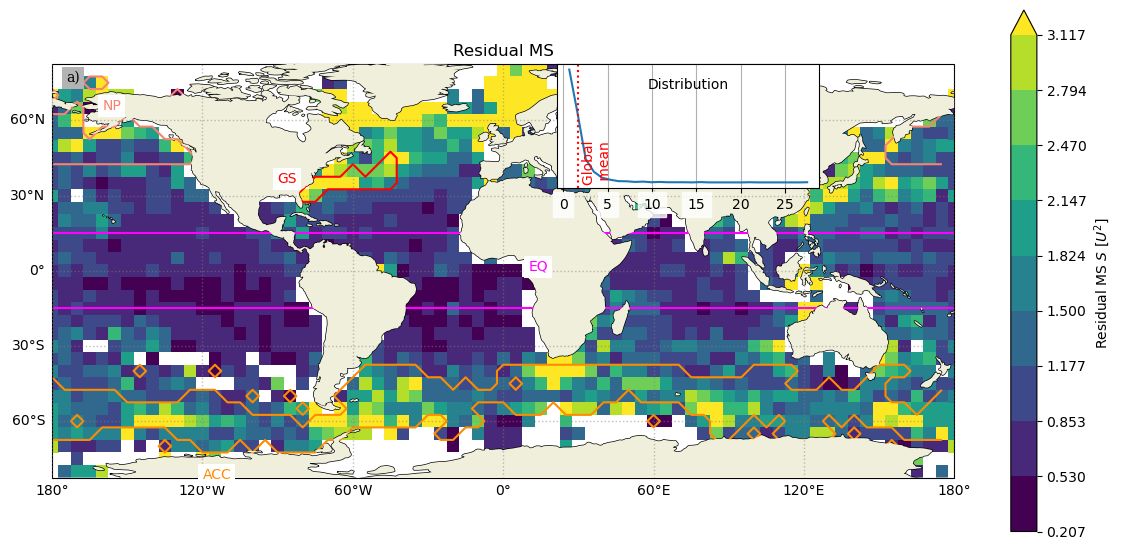

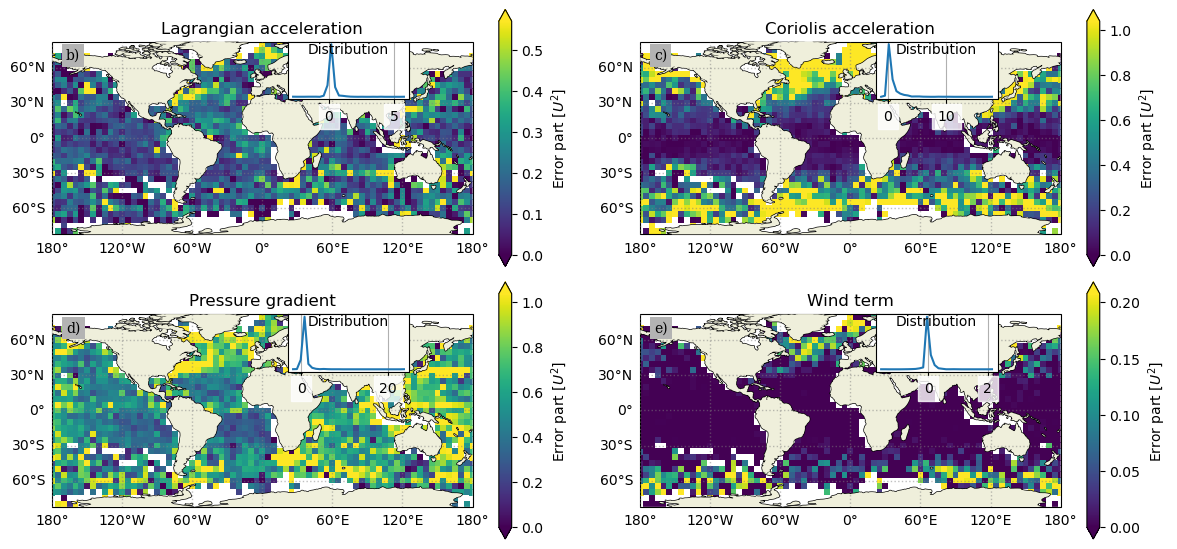

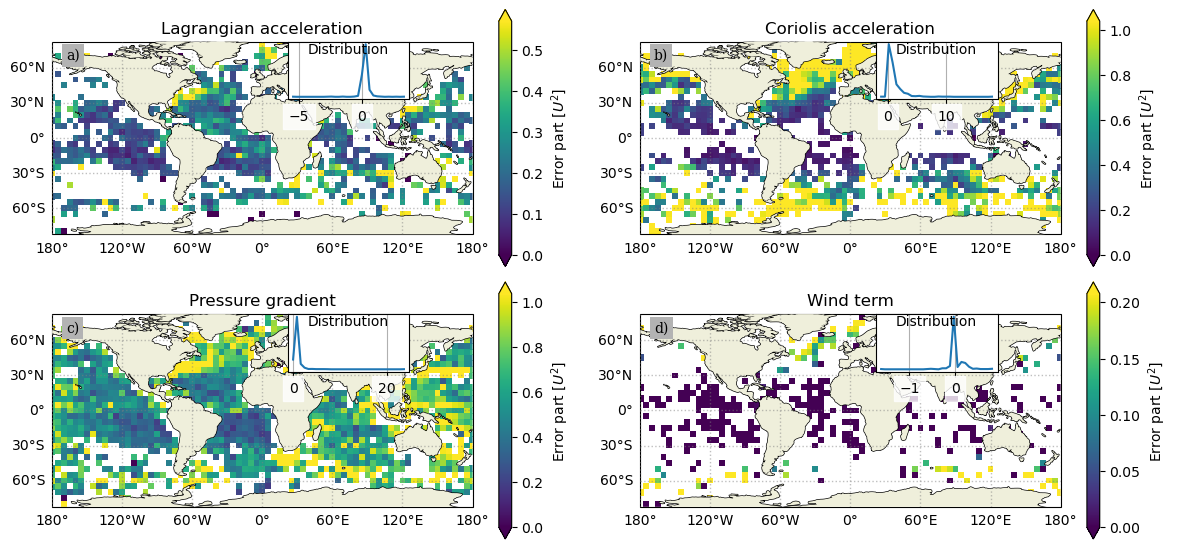

In [44]:
## S Alone
fig, ax = plt.subplots(1,1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(12,5.6), frameon=False)
ds['S'].attrs = {'long_name':r'Residual MS $S$ $[U^2]$'}
ins = plot_lonlat(ds['S'],ax, '', vmax = 3e-10/U2, levels=10, retins=True)
#dsm['sum_'+id_aviso].plot.contour(ax=ax, levels=[2e-10/U2], colors=['red'])
ins.axvline(1.6e-10/U2, color = 'r', ls=':')
ins.annotate('Global \n mean',( 2e-10/U2, 5), color='r', rotation=90)

plot_areas(ax)

ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=3)
ax.set_title('Residual MS')
put_fig_letter(fig, ax, 'a')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
gl.xlabels_top = False
gl.ylabels_right = False
#fig.suptitle('AVISO')
fig.tight_layout(rect=[0,0,1,1])
#fig.savefig('../images_all/lonlat_msre_alg.png', bbox_inches='tight',   dpi=300)



# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(12,5.6), sharex=True, sharey=True, frameon=False)
axs=axs.flatten()
label = 'Error part'

ax=axs[0]
ds['E_acc'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(ds['E_acc'], ax, 'b', vmin =0, vmax=5.5e-11/U2,)
ax.set_title('Lagrangian acceleration')

ax=axs[1]
ds['E_cor'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(ds['E_cor'], ax, 'c', vmin = 0, vmax=1e-10/U2,)
ax.set_title('Coriolis acceleration')

ax=axs[2]
ds['E_ggx'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(ds['E_ggx'], ax, 'd', vmin = 0, vmax=1e-10/U2,)
ax.set_title('Pressure gradient')

ax=axs[3]
ds['E_wd'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(ds['E_wd'], ax, 'e', vmin = 0, vmax=2e-11/U2,)
#ax.set_title('Wind term')
ax.set_title('Wind term')

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Pairs' contributions")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
#fig.savefig('../images_all/lonlat_true_alg_rms.png', bbox_inches='tight', dpi=300)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(12,5.6), sharex=True, sharey=True, frameon=False)
axs=axs.flatten()

label = 'Error part'
lim = elim
cmap = 'viridis'
ax=axs[0]
dsm['E_acc'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(dsm.where(dsm.ratio__E_acc<lim).E_acc, ax, 'a',vmin = 0, vmax=5.5e-11/U2, cmap=cmap)
ax.set_title('Lagrangian acceleration')

ax=axs[1]
dsm['E_cor'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(dsm.where(dsm.ratio__E_cor<lim).E_cor, ax, 'b',vmin = 0, vmax=1e-10/U2, cmap=cmap)
ax.set_title('Coriolis acceleration')

ax=axs[2]
dsm['E_ggx'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(dsm.where(dsm.ratio__E_ggx<lim).E_ggx, ax, 'c',vmin = 0, vmax=1e-10/U2, cmap=cmap)
ax.set_title('Pressure gradient')

ax=axs[3]
dsm['E_wd'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(dsm.where(dsm.ratio__E_wd<lim).E_wd, ax, 'd',vmin = 0, vmax=2e-11/U2, cmap=cmap)
#ax.set_title('Wind term')
ax.set_title('Wind term')

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Pairs' contributions")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
#fig.savefig('../images_all/lonlat_true_alg_rms.png', bbox_inches='tight', dpi=300)

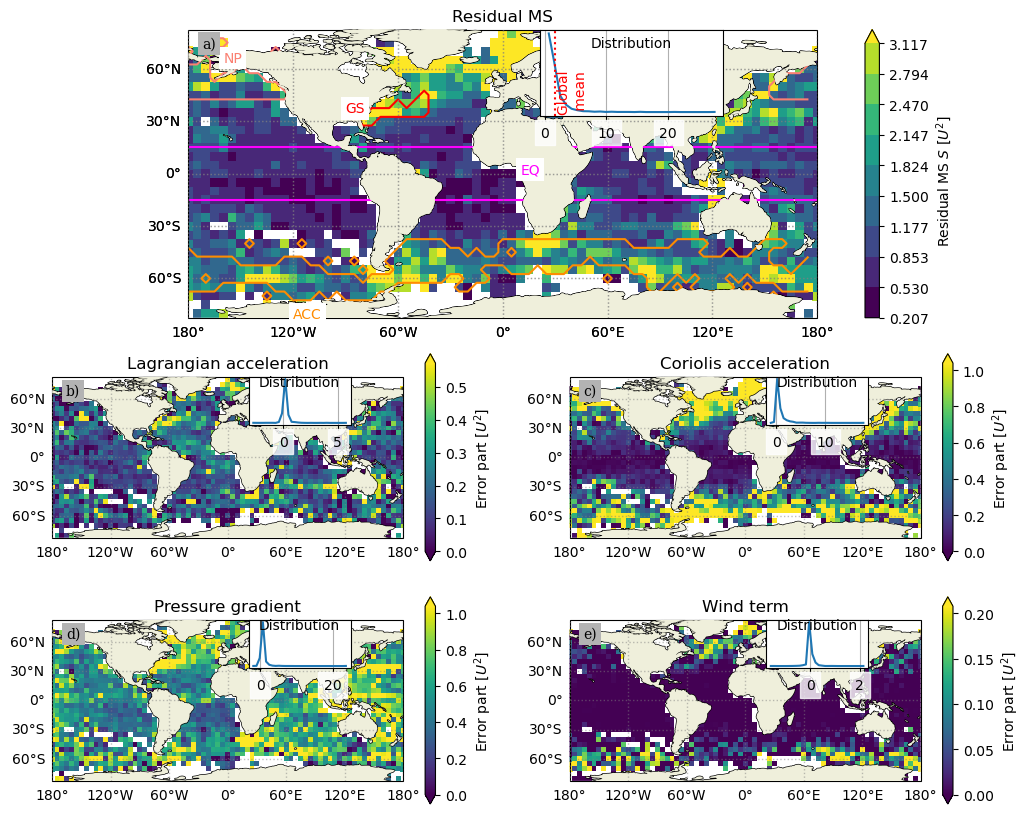

In [45]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure( frameon=False, figsize=(10.5,8.25))

gs = GridSpec(10, 2, figure=fig)
axs = []
i=4
axs.append(fig.add_subplot(gs[:i, :], projection = ccrs.PlateCarree()))
axs.append(fig.add_subplot(gs[i:i+3, 0], projection = ccrs.PlateCarree()))
axs.append(fig.add_subplot(gs[i:i+3, 1], projection = ccrs.PlateCarree()))
axs.append(fig.add_subplot(gs[i+3:i+6, 0], projection = ccrs.PlateCarree()))
axs.append(fig.add_subplot(gs[i+3:i+6, 1], projection = ccrs.PlateCarree()))

ax = axs[0]
ds['S'].attrs = {'long_name':r'Residual MS $S$ $[U^2]$'}
ins = plot_lonlat(ds['S'],ax, '', vmax = 3e-10/U2, levels=10, retins=True)
#dsm['sum_'+id_aviso].plot.contour(ax=ax, levels=[2e-10/U2], colors=['red'])
ins.axvline(1.6e-10/U2, color = 'r', ls=':')
ins.annotate('Global \n mean',( 2e-10/U2, 5), color='r', rotation=90)
plot_areas(ax)
ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=3)
ax.set_title('Residual MS')
put_fig_letter(fig, ax, 'a')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
gl.xlabels_top = False
gl.ylabels_right = False

label = 'Error part'
ax = axs[1]
ds['E_acc'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(ds['E_acc'], ax, 'b', vmin =0, vmax=5.5e-11/U2,)
ax.set_title('Lagrangian acceleration')

ax=axs[2]
ds['E_cor'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(ds['E_cor'], ax, 'c', vmin = 0, vmax=1e-10/U2,)
ax.set_title('Coriolis acceleration')

ax=axs[3]
ds['E_ggx'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(ds['E_ggx'], ax, 'd', vmin = 0, vmax=1e-10/U2,)
ax.set_title('Pressure gradient')

ax=axs[4]
ds['E_wd'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(ds['E_wd'], ax, 'e', vmin = 0, vmax=2e-11/U2,)
#ax.set_title('Wind term')
ax.set_title('Wind term')

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Pairs' contributions")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
#fig.savefig('../images_all/lonlat_true_alg_rms.png', bbox_inches='tight', dpi=300)


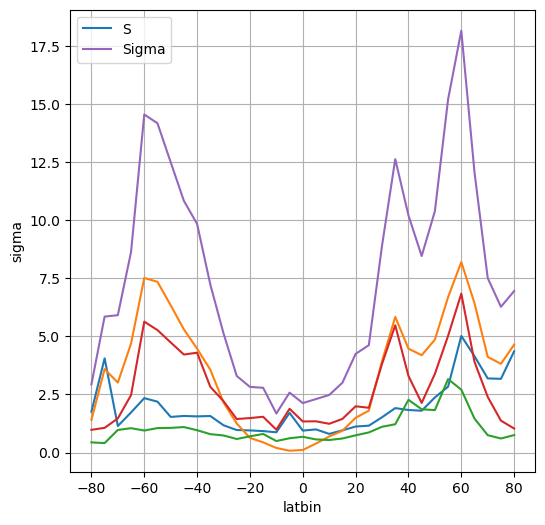

In [46]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ds['S'].mean(dim='lonbin').plot(ax=ax, label='S')
ds['COR'].mean(dim='lonbin').plot(ax=ax)
ds['ACC'].mean(dim='lonbin').plot(ax=ax)
ds['GGX'].mean(dim='lonbin').plot(ax=ax)
ds['sigma'].mean(dim='lonbin').plot(ax=ax, label='Sigma')
ax.legend()
ax.grid()

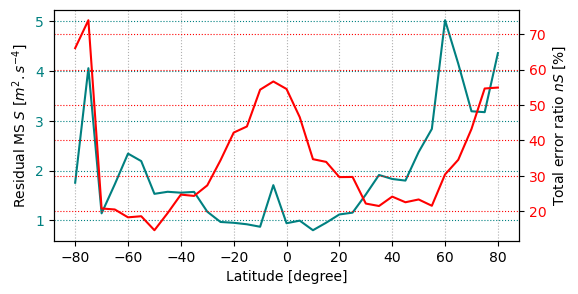

In [47]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
(ds['S']).mean(dim='lonbin').plot(ax=ax, label='nS', color='teal')
ax.set_xlabel('Latitude [degree]')
ax.set_ylabel(r'Residual MS $S$ [$m^2.s^{-4}$]')
ax.tick_params(axis='y', labelcolor='teal')
ax.grid(axis='y',color='teal', ls=':')
ax.grid(axis='x', ls=':')
ax2 = ax.twinx()
(ds['S']/ds['sigma']*100).mean(dim='lonbin').plot(ax=ax2, label='nS', color='r')
ax2.set_xlabel('Latitude [degree]')
ax2.set_ylabel(r'Total error ratio $nS$ [%]')
ax2.tick_params(axis='y', labelcolor='r')
ax2.grid(axis='y',color='r',ls=':')
#fig.savefig('../images_all/lonlat_lat_hist_msre_nmsre_alg.png', bbox_inches='tight',   dpi=300)

_____
# Balanced part

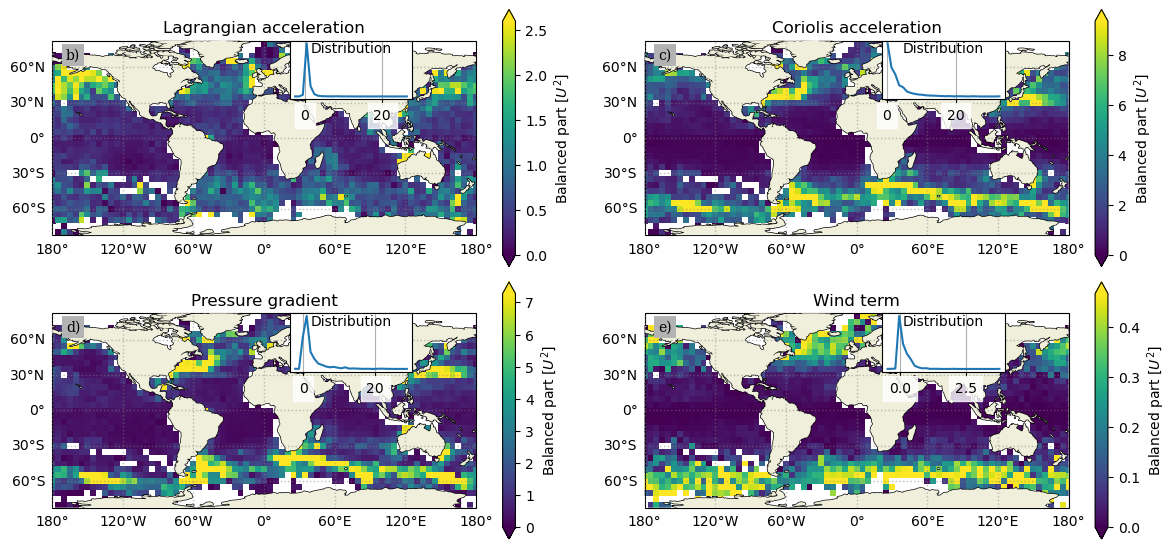

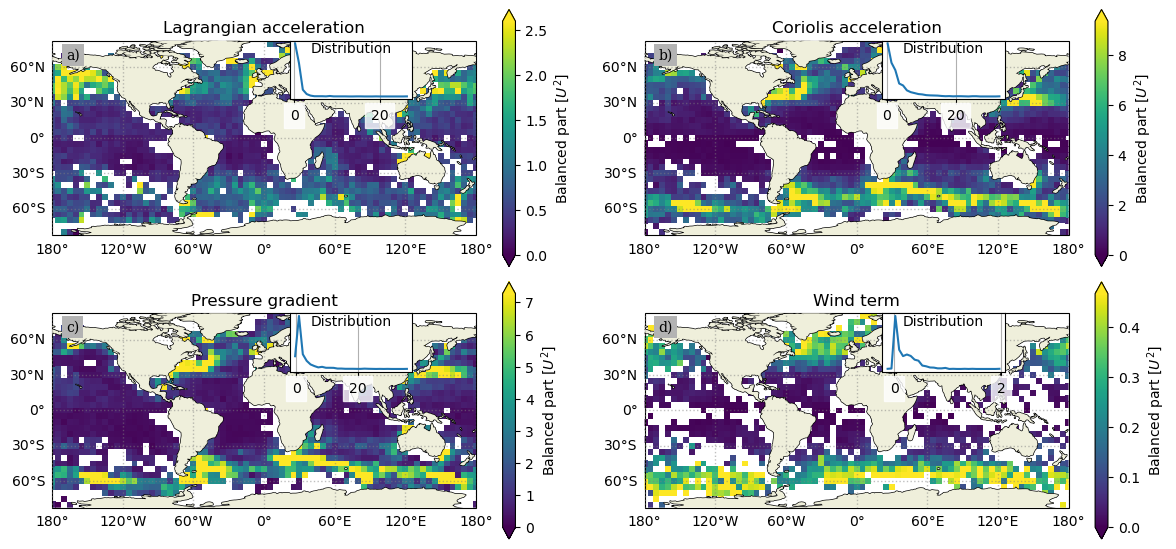

In [48]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(12,5.6), sharex=True, sharey=True, frameon=False)
axs=axs.flatten()
label = 'Balanced part'

ax=axs[0]
ds['B_acc'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(ds['B_acc'], ax, 'b', vmin =0, vmax=2.5e-10/U2,)
ax.set_title('Lagrangian acceleration')

ax=axs[1]
ds['B_cor'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(ds['B_cor'], ax, 'c', vmin = 0, vmax=9e-10/U2,)
ax.set_title('Coriolis acceleration')

ax=axs[2]
ds['B_ggx'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(ds['B_ggx'], ax, 'd', vmin = 0, vmax=7e-10/U2,)
ax.set_title('Pressure gradient')

ax=axs[3]
ds['B_wd'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(ds['B_wd'], ax, 'e', vmin = 0, vmax=4.5e-11/U2,)
#ax.set_title('Wind term')
ax.set_title('Wind term')

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Pairs' contributions")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
#fig.savefig('../images_all/lonlat_true_alg_rms.png', bbox_inches='tight', dpi=300)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(12,5.6), sharex=True, sharey=True, frameon=False)
axs=axs.flatten()

lim = elim
cmap = 'viridis'
ax=axs[0]
dsm['B_acc'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(dsm.where(dsm.ratio__B_acc<lim).B_acc, ax, 'a',vmin = 0, vmax=2.5e-10/U2, cmap=cmap)
ax.set_title('Lagrangian acceleration')

ax=axs[1]
dsm['B_cor'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(dsm.where(dsm.ratio__B_cor<lim).B_cor, ax, 'b',vmin = 0, vmax=9e-10/U2, cmap=cmap)
ax.set_title('Coriolis acceleration')

ax=axs[2]
dsm['B_ggx'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(dsm.where(dsm.ratio__B_ggx<lim).B_ggx, ax, 'c',vmin = 0, vmax=7e-10/U2, cmap=cmap)
ax.set_title('Pressure gradient')

ax=axs[3]
dsm['B_wd'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(dsm.where(dsm.ratio__B_wd<lim).B_wd, ax, 'd',vmin = 0, vmax=4.5e-11/U2, cmap=cmap)
#ax.set_title('Wind term')
ax.set_title('Wind term')

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Pairs' contributions")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
#fig.savefig('../images_all/lonlat_true_alg_rms.png', bbox_inches='tight', dpi=300)

______________________
# Pairs contribution


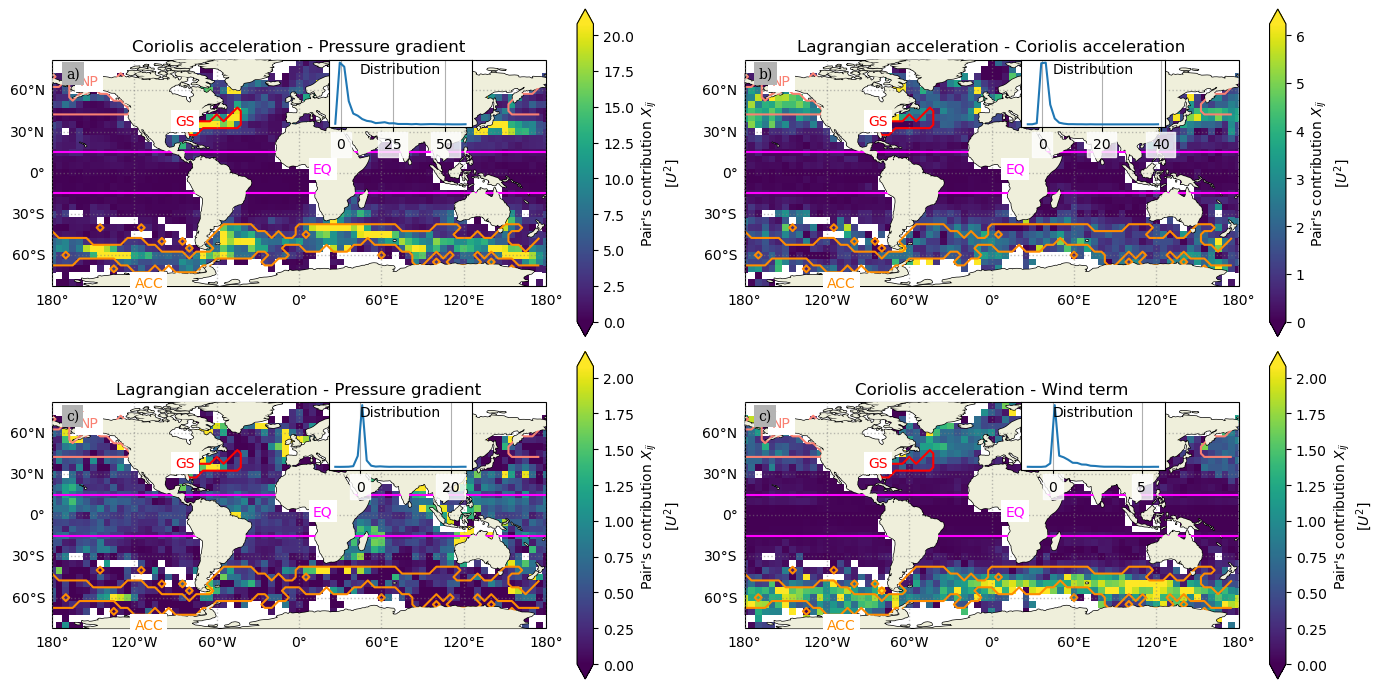

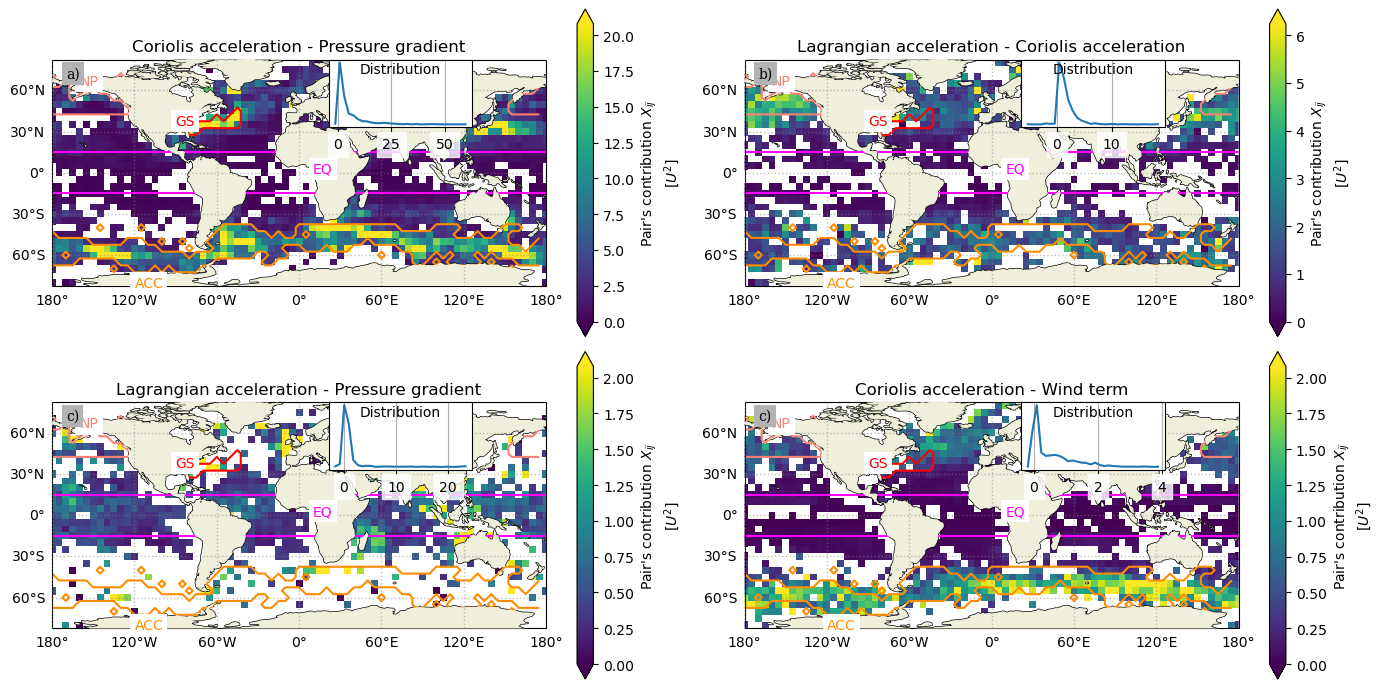

In [77]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,7), sharex=True, sharey=True, frameon=False)
title = ['Coriolis acceleration - Pressure gradient', 'Lagrangian acceleration - Coriolis acceleration', 'Lagrangian acceleration - Pressure gradient','Coriolis acceleration - Wind term',]
axs=axs.flatten()

label = r"Pair's contribution $X_{ij}$"
ax=axs[0]
ds['X_cor_ggx'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(ds['X_cor_ggx'], ax, 'a', vmin = 0, vmax=2e-9/U2,)
plot_areas(ax)
ax.set_title(title[0])

ax=axs[1]
ds['X_acc_cor'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(ds['X_acc_cor'], ax, 'b', vmin = 0, vmax=6e-10/U2,)
plot_areas(ax)
ax.set_title(title[1])

ax=axs[2]
ds['X_acc_ggx'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(ds['X_acc_ggx'], ax, 'c', vmin = 0, vmax = 2e-10/U2,)
plot_areas(ax)
ax.set_title(title[2])

ax=axs[3]
ds['X_cor_wd'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(ds['X_cor_wd'], ax, 'c', vmin = 0, vmax = 2e-10/U2,)
plot_areas(ax)
ax.set_title(title[3])

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Along-track")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
#fig.savefig('../images_all/lonlat_pair_alg.png', bbox_inches='tight',   dpi=300)


# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,7), sharex=True, sharey=True, frameon=False)
title = ['Coriolis acceleration - Pressure gradient', 'Lagrangian acceleration - Coriolis acceleration', 'Lagrangian acceleration - Pressure gradient','Coriolis acceleration - Wind term',]
axs=axs.flatten()

label = r"Pair's contribution $X_{ij}$"
ax=axs[0]
dsm['X_cor_ggx'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(dsm.where(dsm.ratio__X_cor_ggx<elim)['X_cor_ggx'], ax, 'a', vmin = 0, vmax=2e-9/U2,)
plot_areas(ax)
ax.set_title(title[0])

ax=axs[1]
dsm['X_acc_cor'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(dsm.where(dsm.ratio__X_acc_cor<elim)['X_acc_cor'], ax, 'b', vmin = 0, vmax=6e-10/U2,)
plot_areas(ax)
ax.set_title(title[1])

ax=axs[2]
dsm['X_acc_ggx'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(dsm.where(dsm.ratio__X_acc_ggx<elim)['X_acc_ggx'], ax, 'c', vmin = 0, vmax = 2e-10/U2,)
plot_areas(ax)
ax.set_title(title[2])

ax=axs[3]
dsm['X_cor_wd'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(dsm.where(dsm.ratio__X_cor_wd<elim)['X_cor_wd'], ax, 'c', vmin = 0, vmax = 2e-10/U2,)
plot_areas(ax)
ax.set_title(title[3])

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Along-track")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
#fig.savefig('../images_all/lonlat_pair_alg.png', bbox_inches='tight',   dpi=300)


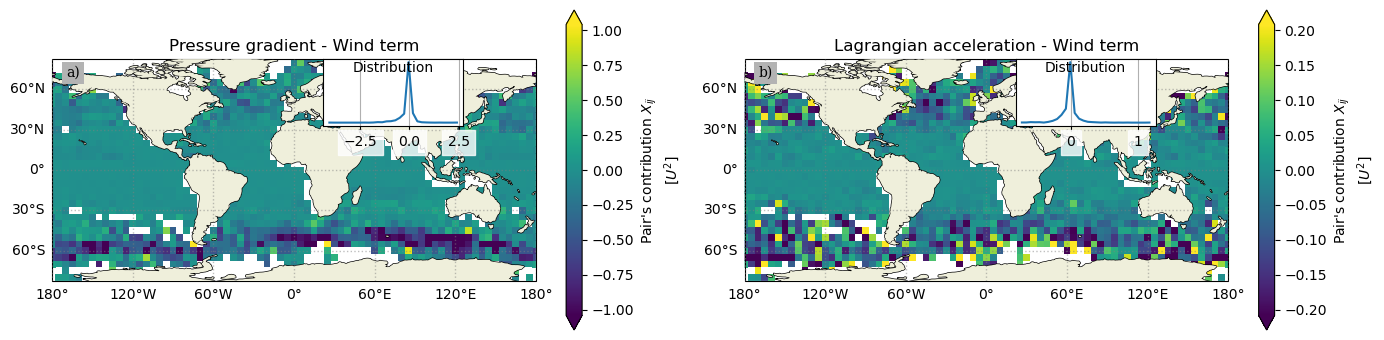

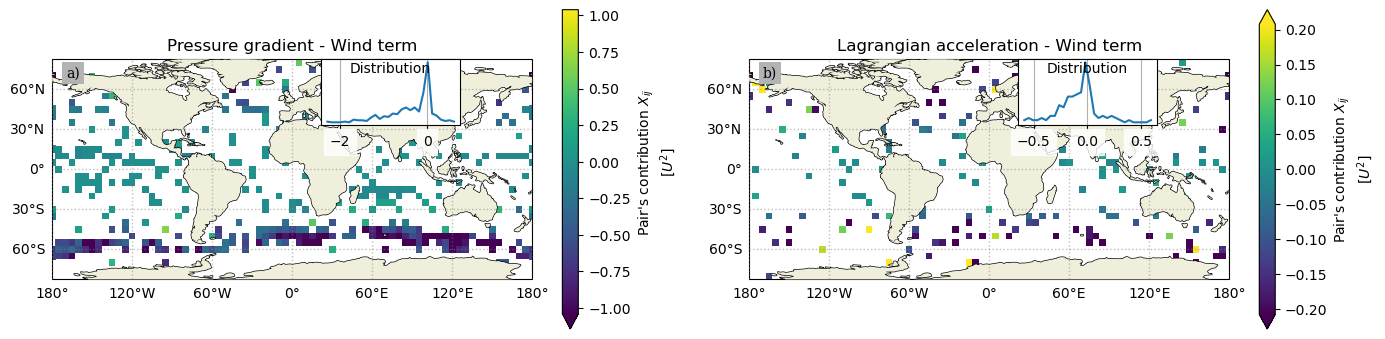

In [81]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(1,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,3.5), sharex=True, sharey=True, frameon=False)
title = ['Pressure gradient - Wind term','Lagrangian acceleration - Wind term']
axs=axs.flatten()

label = r"Pair's contribution $X_{ij}$"
ax=axs[0]
ds['X_ggx_wd'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(ds['X_ggx_wd'], ax, 'a',vmin = -1e-10/U2, vmax = 1e-10/U2,)
ax.set_title(title[0])

ax=axs[1]
ds['X_acc_wd'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(ds['X_acc_wd'], ax, 'b',vmin = -2e-11/U2, vmax =2e-11/U2,)
ax.set_title(title[1])

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Along-track")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
#fig.savefig('../images_all/lonlat_other_pair_alg.png', bbox_inches='tight',   dpi=300)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(1,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,3.5), sharex=True, sharey=True, frameon=False)
title = ['Pressure gradient - Wind term','Lagrangian acceleration - Wind term']
axs=axs.flatten()

label = r"Pair's contribution $X_{ij}$"
ax=axs[0]
dsm['X_ggx_wd'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(dsm.where(dsm.ratio__X_ggx_wd<elim)['X_ggx_wd'], ax, 'a',vmin = -1e-10/U2, vmax = 1e-10/U2,)
ax.set_title(title[0])

ax=axs[1]
dsm['X_acc_wd'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(dsm.where(dsm.ratio__X_acc_wd<elim)['X_acc_wd'], ax, 'b',vmin = -2e-11/U2, vmax =2e-11/U2,)
ax.set_title(title[1])

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Along-track")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
#fig.savefig('../images_all/lonlat_other_pair_alg.png', bbox_inches='tight',   dpi=300)

## Sum of individual term MSs $\Sigma$

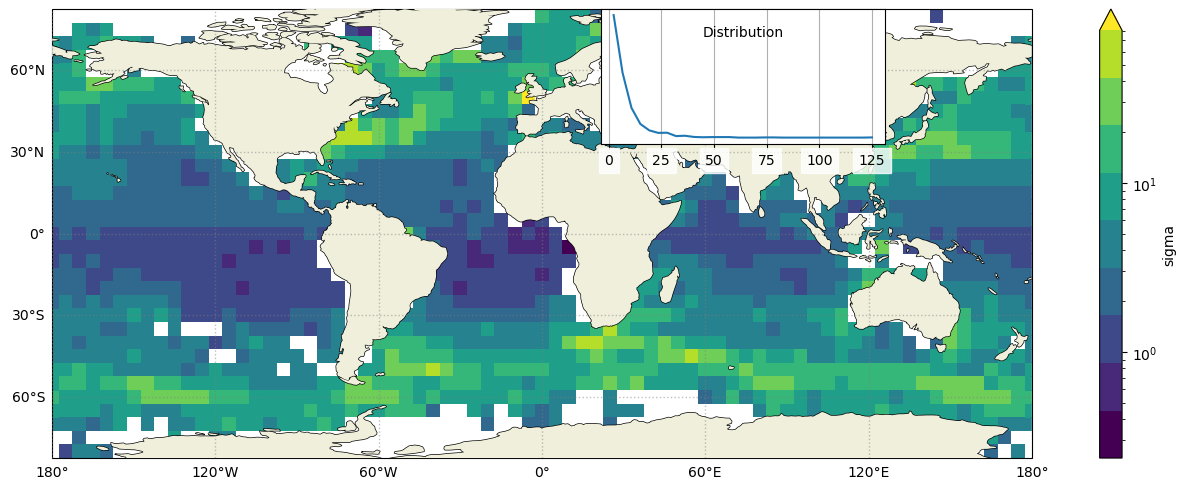

In [79]:
import matplotlib.colors as colors
fig, ax = plt.subplots(1,1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,5), frameon=False)
#ds['S'].plot.contour(ax=ax, levels=[2e-10/U2], colors=['red'], transform=ccrs.PlateCarree())
plot_lonlat(dsm.where(dsm.ratio__sigma<elim)['sigma'],ax, levels=10, norm=colors.LogNorm(vmin=ds['sigma'].min(), vmax=ds['sigma'].max()))
#ds['S'].plot.contour(ax=ax, levels=[7e-11], colors=['orange'], transform=ccrs.PlateCarree())
#ins.axvline(7e-11, color = 'orange')
ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
gl.xlabels_top = False
gl.ylabels_right = False
#fig.suptitle('Along-track')
fig.tight_layout(rect=[0,0,1,1])
#fig.savefig('../images_all/lonlat_sigma_alg.png', bbox_inches='tight',   dpi=300)


## Relative error on the residual

Text(0.5, 1.0, 'Along-track')

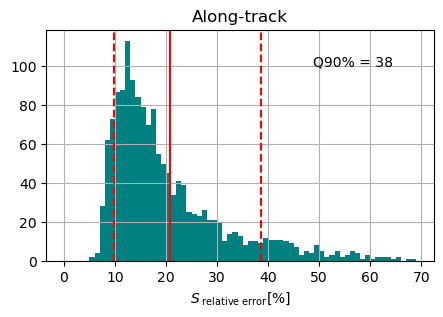

In [26]:
dd = 10
_ds = ds.where(ds.nb_coloc_bin >0).nb_coloc_bin
fig, ax = plt.subplots(1,1, figsize=(5,3))
hist = ne.plot.hist(bins=np.arange(0,70, 1), ax=ax, color='teal')
mean = ne.mean().values
q90 = ne.quantile(0.9).values
q10 = ne.quantile(0.1).values
ax.axvline(mean, color = 'red')
ax.axvline(q90, color = 'red', ls='--')
ax.axvline(q10, color = 'red', ls='--')
ax.annotate(f'Q10% ={int(q10)}',(q10+dd, 300))
ax.annotate(f'Q90% = {int(q90)}',(q90+dd, 100))
ax.annotate(f'QMean% = {int(mean)}',(mean+dd, 200))
ax.grid()
ax.set_title('Along-track')


## Contribution normalized by $\Sigma$

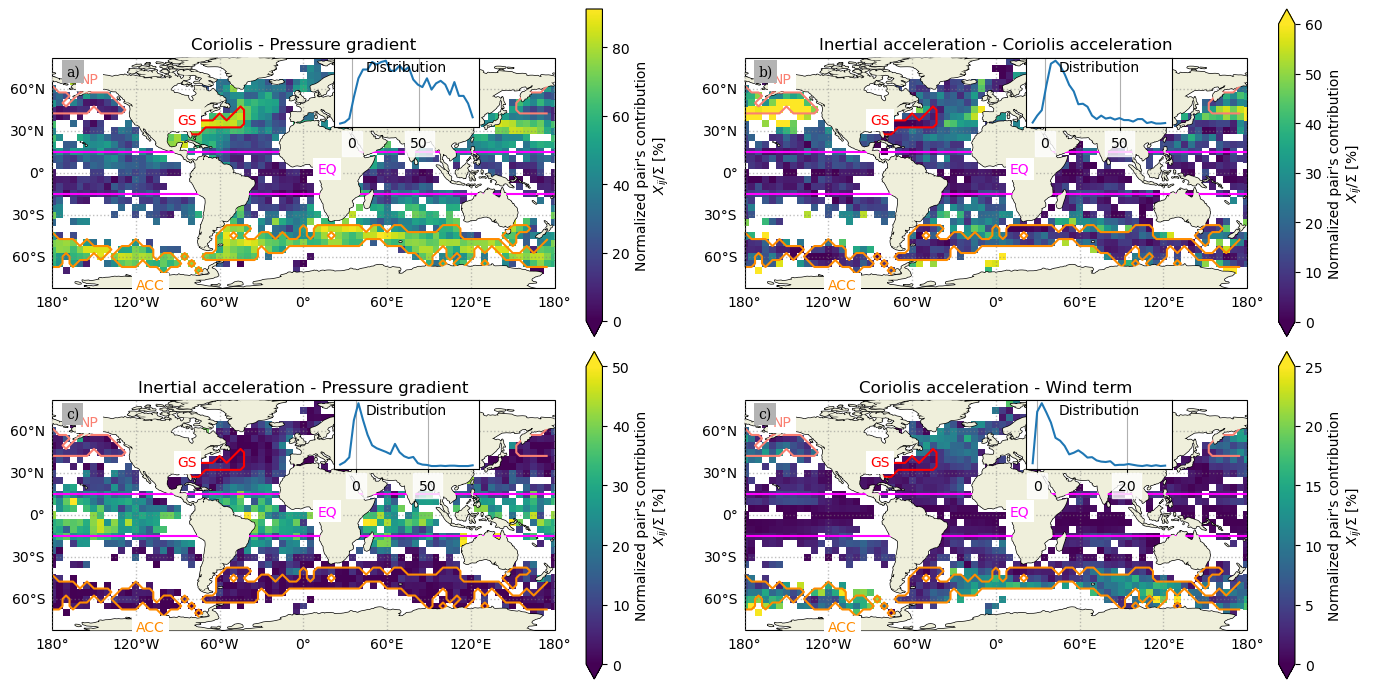

In [29]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,7), sharex=True, sharey=True, frameon=False)
title = ['Coriolis - Pressure gradient', 'Lagrangian acceleration - Coriolis acceleration', 'Lagrangian acceleration - Pressure gradient','Coriolis acceleration - Wind term',]
axs=axs.flatten()

label = r"Normalized pair's contribution $X_{ij}/\Sigma$"
ax=axs[0]
ds['X_cor_ggx__sigma'].attrs={'long_name':label, 'unit':'%'}
ins = plot_lonlat(ds['X_cor_ggx__sigma'], ax, 'a', vmin = 0, retins=True)
plot_areas(ax)
#dsm['X_cor_ggx'].plot.contour(ax=ax, levels=[70], colors=['red'], transform=ccrs.PlateCarree())
#ins.axvline(70, color = 'r')
ax.set_title(title[0])

ax=axs[1]
ds['X_acc_cor__sigma'].attrs={'long_name':label, 'unit':'%'}
ins = plot_lonlat(ds['X_acc_cor__sigma'], ax, 'b', vmin = 0, vmax=60, retins=True)
plot_areas(ax)
#dsm['X_acc_cor'].plot.contour(ax=ax, levels=[60], colors=['red'], transform=ccrs.PlateCarree())
#ins.axvline(60, color = 'r')
ax.set_title(title[1])


ax=axs[2]
ds['X_acc_ggx__sigma'].attrs={'long_name':label, 'unit':'%'}
ins= plot_lonlat(ds['X_acc_ggx__sigma'], ax, 'c', vmin = 0, vmax=50, retins=True)
#dsm['X_acc_ggx'].plot.contour(ax=ax, levels=[25], colors=['red'], transform=ccrs.PlateCarree())
plot_areas(ax)
#acc.plot.contour(ax=ax, levels=1, colors=['red'], transform=ccrs.PlateCarree())
#ins.axvline(30, color = 'r')
ax.set_title(title[2])

ax=axs[3]
ds['X_cor_wd__sigma'].attrs={'long_name':label, 'unit':'%'}
ins = plot_lonlat(ds['X_cor_wd__sigma'], ax, 'c', vmin = 0, vmax=25, retins=True)
plot_areas(ax)
#dsm['X_cor_wind'].plot.contour(ax=ax, levels=[10], colors=['red'], transform=ccrs.PlateCarree())
#ins.axvline(10, color = 'r')
ax.set_title(title[3])

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Along-track")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
#fig.savefig('../images_all/lonlat_pair_normalized_alg.png',  bbox_inches='tight',  dpi=300)

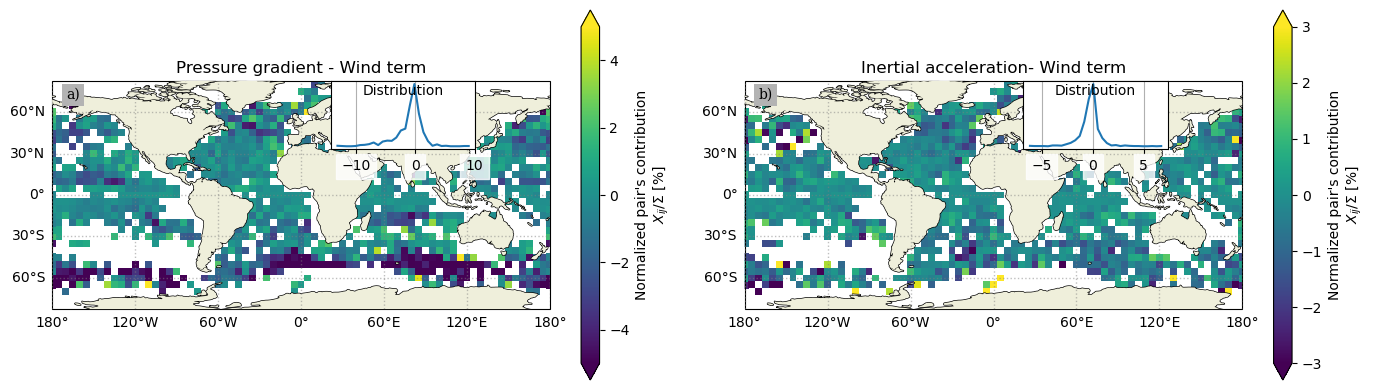

In [30]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(1,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,4), sharex=True, sharey=True, frameon=False)
title = ['Pressure gradient - Wind term','Lagrangian acceleration- Wind term']
axs=axs.flatten()

label = r"Normalized pair's contribution $X_{ij}/\Sigma$"
ax=axs[0]
ds['X_ggx_wd__sigma'].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(ds['X_ggx_wd__sigma'], ax, 'a',vmin = -5, vmax = 5,)
ax.set_title(title[0])

ax=axs[1]
ds['X_acc_wd__sigma'].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(ds['X_acc_wd__sigma'], ax, 'b',vmin = -3, vmax = 3,)
ax.set_title(title[1])

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Along-track")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
#fig.savefig('../images_all/lonlat_other_pair_normalized_alg.png', bbox_inches='tight',   dpi=300)

In [31]:
ds

<xarray.Dataset>
Dimensions:                 (latbin: 33, lonbin: 72)
Coordinates:
  * latbin                  (latbin) float64 -80.0 -75.0 -70.0 ... 75.0 80.0
  * lonbin                  (lonbin) float64 -180.0 -175.0 ... 170.0 175.0
Data variables: (12/73)
    obs                     (latbin, lonbin) float64 nan nan nan ... nan nan nan
    acc                     (latbin, lonbin) float64 nan nan nan ... nan nan nan
    cor                     (latbin, lonbin) float64 nan nan nan ... nan nan nan
    drogue_status           (latbin, lonbin) float64 nan nan nan ... nan nan nan
    ggx                     (latbin, lonbin) float64 nan nan nan ... nan nan nan
    wd                      (latbin, lonbin) float64 nan nan nan ... nan nan nan
    ...                      ...
    be__X_acc_ggx__sigma    (latbin, lonbin) float64 nan nan nan ... nan nan nan
    be__X_acc_wd__sigma     (latbin, lonbin) float64 nan nan nan ... nan nan nan
    be__X_cor_ggx__sigma    (latbin, lonbin) float64 nan nan nan ... nan nan nan
    be__X_cor_wd__sigma     (latbin, lonbin) float64 nan nan nan ... nan nan nan
    be__X_ggx_wd__sigma     (latbin, lonbin) float64 nan nan nan ... nan nan nan
    be__GGX__sigma          (latbin, lonbin) float64 nan nan nan ... nan nan nan

__________
# Investigate negative balanced and error parts

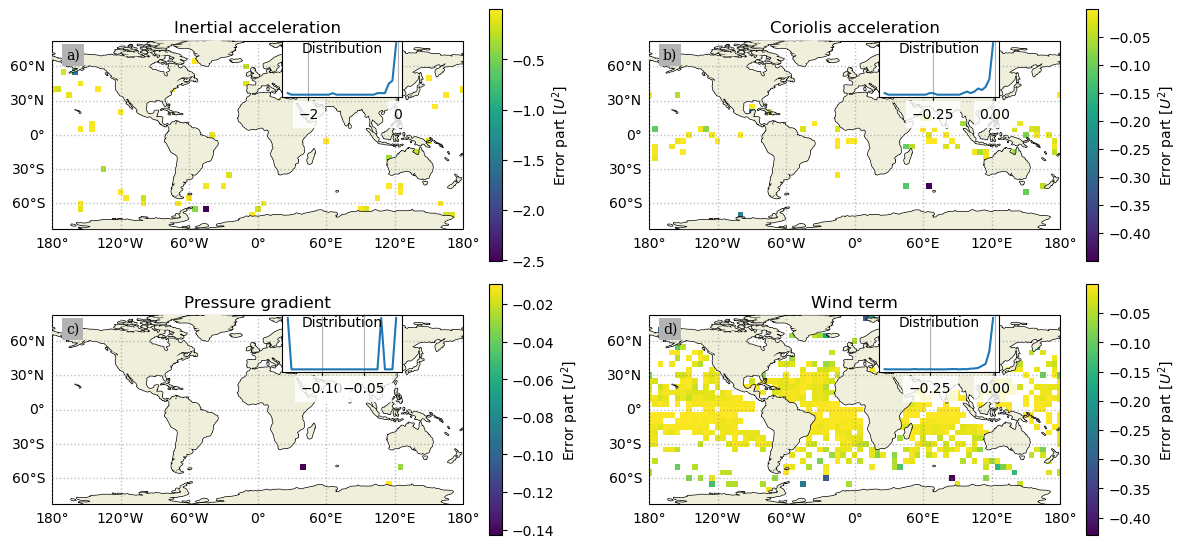

In [92]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(12,5.6), sharex=True, sharey=True, frameon=False)
axs=axs.flatten()
label = 'Error part'

ax=axs[0]
ds['E_acc'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(ds.where(ds.E_acc<0)['E_acc'], ax, 'a', )
ax.set_title('Lagrangian acceleration')

ax=axs[1]
ds['E_cor'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(ds.where(ds.E_cor<0)['E_cor'], ax, 'b',)
ax.set_title('Coriolis acceleration')

ax=axs[2]
ds.where(ds.E_ggx<0)['E_ggx'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(ds.where(ds.E_ggx<0)['E_ggx'], ax, 'c',)
ax.set_title('Pressure gradient')

ax=axs[3]
ds['E_wd'].attrs={'long_name':label, 'unit':r'$U^2$'}
plot_lonlat(ds.where(ds.E_wd<0)['E_wd'], ax, 'd',)
#ax.set_title('Wind term')
ax.set_title('Wind term')

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Pairs' contributions")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
#fig.savefig('../images_all/lonlat_true_alg_rms.png', bbox_inches='tight', dpi=300)